# INSTALL

In [1]:
# Устанавливаем недостающие библиотеки
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-8tn3c6iv
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=28027 sha256=8a041a6f8dd39edeec516a9b386034a2d8eb767808ba7f0154f6d9bacf4996c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-23z1ei7y/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


# INPUT

In [2]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os

# TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as M
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import *
import tensorflow.keras.layers as L

# Вместо ImageDataGenerator будем использовать ImageDataAugmentor. Это обертка для трех основных генераторов:
# - ImageDataGenerator
# - albumentations
# - imgaug
# Документация: https://github.com/mjkvaak/ImageDataAugmentor
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as alb

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input/sf-dl-car-classification/"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.csv', 'test.zip', 'train.zip', 'sample-submission.csv']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


# PREPARE FOR WORK

In [3]:
DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/" # рабочая директория

# Создаем рабочую директорию
os.makedirs(PATH,exist_ok=False)

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [4]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


# EDA

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


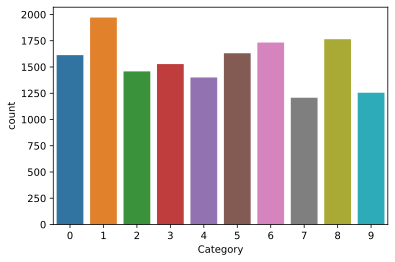

In [5]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
display(train_df.head())
train_df.info()

# Посмотрим на распределение классов в датасете
sns.countplot(x='Category', data=train_df)

Посмотрим, что из себя представляют изображения

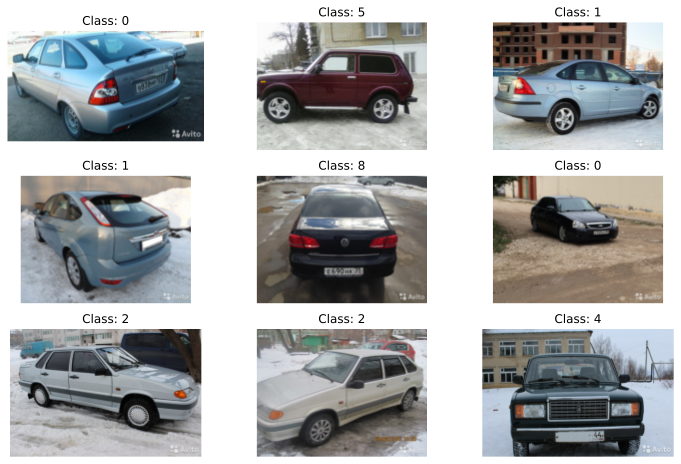

In [6]:
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на оригинальный размер изображения

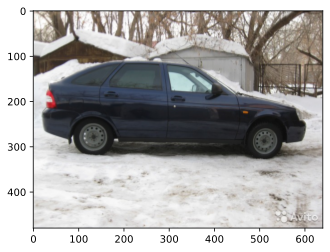

Размер изображения: (640, 480)


In [7]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
print('Размер изображения:',image.size)

# PREPARING DATA

Для аугмmентаций будем использовать оболочку ImageDataAugmentor. Она объединяет в себе несколько библиотек: 
- **ImageDataGenerator**;
- **albumentations**;
- **imgaug**.

Для данного проекта воспользуемся библиотекой **albumentations**



In [8]:
# def visualize(image):
#     plt.figure(figsize=(10, 10))
#     plt.axis('off')
#     plt.imshow(image)

In [9]:
# # Блок для тестирования аугментаций
# image = cv2.imread(PATH+'/train/0/100380.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# transform = alb.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, approximate=False, p=0.5)
# augmented_image = transform(image=image)['image']
# visualize(augmented_image)

In [10]:
# Невозможно загрузить в сеть сразу все данные
# поэтому используют batch. Разбивают данные на
# батчи (паки) с определенным количеством данных
# внутри, которые подаются на обучения за раз.
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 250 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [11]:
# Сделаем таким образом, чтобы для изображения применялся случайный набор аугментаций

AUGMENTATIONS = alb.Compose([
    alb.OneOf([                                  # выбираем вариант разворота изображения
#         alb.RandomRotate90(),
#         alb.Flip(),
#         alb.HorizontalFlip(),
#         alb.VerticalFlip(),
#         alb.Transpose(),
#         alb.Rotate(),
#         alb.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, approximate=False)
    ], p = 0.6),
    alb.OneOf([
        alb.ToSepia(),
        alb.ToGray(),              
    ], p = 0.3),
    alb.OneOf([
        alb.ChannelShuffle(),
        alb.ChannelDropout()        
    ], p=0.3),
    alb.OneOf([                                 # выбираем один из вариантов размытия изображения
        alb.MotionBlur(blur_limit=3),
        alb.MedianBlur(blur_limit=3),
        alb.Blur(blur_limit=3)        
    ], p = 0.3),
    alb.OneOf([
        alb.IAAAdditiveGaussianNoise(),         # выбираем один из видов шумов
        alb.GaussNoise(),
        alb.ISONoise()
    ], p = 0.3),
    alb.JpegCompression(quality_lower=12, quality_upper=100, p=0.3),   # компрессия
    alb.RandomBrightnessContrast(0.2, 0.2, p=0.3)
])

После многих попыток установил, что любая из аугментаций которая поворачивает или переворачивает изображение очень сильно ухудшает итоговый результат.

In [12]:
train_datagen = ImageDataAugmentor(
    rescale = 1./ 255,
    augment = AUGMENTATIONS,
    validation_split = VAL_SPLIT
)

test_datagen = ImageDataAugmentor(rescale=1. / 255)

In [13]:
# # Официальная документация: https://keras.io/preprocessing/image/

# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     validation_split=VAL_SPLIT, # set validation split
#     horizontal_flip=False)

# test_datagen = ImageDataGenerator(rescale=1. / 255) # аугментация для тестовых данных не делается, чтобы
#                                                     # проводить проверку на чистых, не аугментированных данных

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


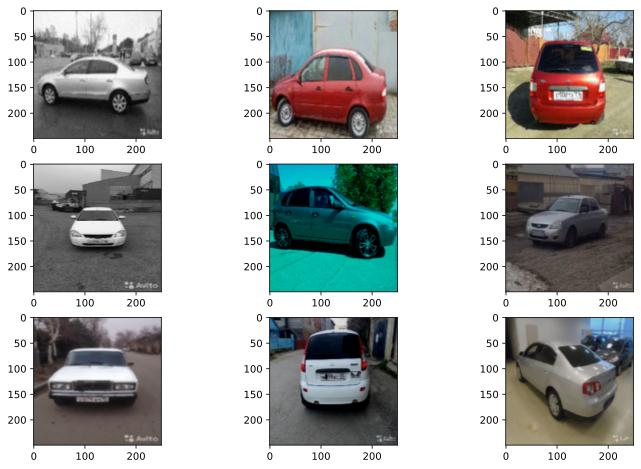

In [14]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

x,y = train_generator.next()
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

# MODEL

In [15]:
print('Размер входного изображения и количество каналов:',input_shape)

Размер входного изображения и количество каналов: (250, 250, 3)


#### Для улучшения результата воспоьзуемся методом **transfer learning**.

Чтобы подобрать модель воспользуемся сайтом [Paper with code](https://paperswithcode.com/sota/image-classification-on-imagenet). Здесь можно найти рейтинг и описание всех популярных моделей, а так же описание в каких область они применяются. В нашем случаи воспользуемся imagenet, а именно **EfficientNetB6**, так эта модель имеет небольшое количество параметров относительно других моделей и показывает хороший результат.

In [16]:
EPOCHS               = 5  # эпох на обучение
LR                   = 1e-4 # learning rate

In [17]:
base_model = tf.keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape = input_shape)
# weights='imagenet' - используем веса обученые на imagenet
# include_top=False - не используем выходы, которые использовались на imagenet (более 1000 классов). Для нашей задачи необходимо 10 выходных классов
# input_shape = input_shape - размер изображений

# base_model.trainable = True

base_model.summary()

165240832/165234480 [==============================] - 3s 0us/step
Model: "efficientnetb6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 250, 250, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 251, 251, 3)  0           normalization[0][0]              
__________________

Устанавливаем свою "голову"

In [18]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D()) # объединяет все признаки в единый вектор
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(rate=0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 8, 8, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,817
Trainable params: 41,328,866
Non-trainable params: 224,951
______________________________________

In [19]:
print('Количество слоев: {}'.format(len(model.layers)))
print('Количетсво обучаемых слоев: {}\n'.format(len(model.trainable_variables)))

for layer in model.layers:
    print(layer, layer.trainable)

Количество слоев: 6
Количетсво обучаемых слоев: 588

<tensorflow.python.keras.engine.functional.Functional object at 0x7f6b39bf4310> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f6b39b24210> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f6b384d1810> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6b384c7c90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f6b3846a410> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f6b38483c10> True


# FIT

In [20]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [21]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [22]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
827/827 [==============================] - ETA: 0s - loss: 1.2893 - accuracy: 0.5794
Epoch 00001: saving model to best_model.hdf5
827/827 [==============================] - 520s 629ms/step - loss: 1.2893 - accuracy: 0.5794 - val_loss: 0.5114 - val_accuracy: 0.8233
Epoch 2/5
827/827 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8629
Epoch 00002: saving model to best_model.hdf5
827/827 [==============================] - 517s 625ms/step - loss: 0.3908 - accuracy: 0.8629 - val_loss: 0.2584 - val_accuracy: 0.9142
Epoch 3/5
827/827 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9188
Epoch 00003: saving model to best_model.hdf5
827/827 [==============================] - 517s 625ms/step - loss: 0.2319 - accuracy: 0.9188 - val_loss: 0.2913 - val_accuracy: 0.9047
Epoch 4/5
827/827 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.9426
Epoch 00004: saving model to best_model.hdf5
827/827 [==========================

In [23]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [24]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 31s 209ms/step - loss: 0.2564 - accuracy: 0.9219
Accuracy: 92.19%


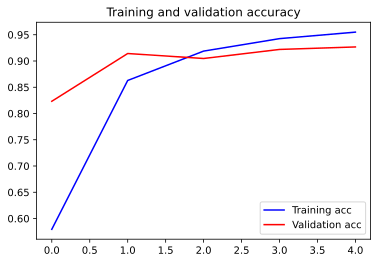

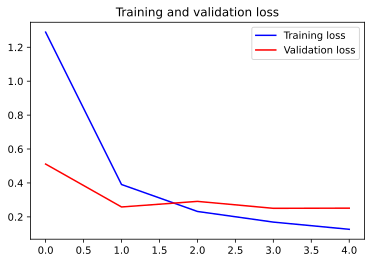

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# PREDICTION

In [26]:
test_sub_generator.samples

6675

In [27]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

418/418 [==============================] - 60s 144ms/step


In [28]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [29]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


# TTA

In [30]:
model.load_weights('best_model.hdf5')

In [31]:
AUGMENTATIONS = alb.Compose([
    alb.OneOf([                                  # выбираем вариант разворота изображения
#         alb.RandomRotate90(),
#         alb.Flip(),
#         alb.HorizontalFlip(),
#         alb.VerticalFlip(),
#         alb.Transpose(),
#         alb.Rotate(),
#         alb.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, approximate=False)
    ], p = 0.6),
    alb.OneOf([
        alb.ToSepia(),
        alb.ToGray(),              
    ], p = 0.3),
    alb.OneOf([
        alb.ChannelShuffle(),
        alb.ChannelDropout()        
    ], p=0.3),
    alb.OneOf([                                 # выбираем один из вариантов размытия изображения
        alb.MotionBlur(blur_limit=3),
        alb.MedianBlur(blur_limit=3),
        alb.Blur(blur_limit=3)        
    ], p = 0.3),
    alb.OneOf([
        alb.IAAAdditiveGaussianNoise(),         # выбираем один из видов шумов
        alb.GaussNoise(),
        alb.ISONoise()
    ], p = 0.3),
    alb.JpegCompression(quality_lower=12, quality_upper=100, p=0.3),   # компрессия
    alb.RandomBrightnessContrast(0.2, 0.2, p=0.3)
])

test_datagen = ImageDataAugmentor(
    rescale = 1./ 255,
    augment = AUGMENTATIONS,
    validation_split = VAL_SPLIT
)

In [32]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [33]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

418/418 [==============================] - 90s 216ms/step


In [34]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [35]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit
